In [4]:
from pathlib import Path
from tensorflow.python.keras.callbacks import EarlyStopping
from keras.models import Model, load_model

import pandas as pd
from imutils import build_montages
import numpy as np
import cv2
from tqdm.notebook import tqdm
from pprint import pprint
import os
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import skimage
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, GlobalAveragePooling2D, MaxPooling2D, Lambda

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
for gpu in physical_devices:
    tf.config.experimental.set_memory_growth(gpu, True)
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# load/preprocess images

In [6]:
DATA_DIR = Path('./frgc32x32/')
images = [x.name for x in DATA_DIR.glob('*')]

In [7]:
image_paths = list(DATA_DIR.glob('*.png'))
user_id = [x.name.split('d')[0] for x in image_paths]
user_img_id = [x.name.split('d')[1].replace('.png', '') for x in image_paths]

directory_df = pd.DataFrame({
    'user_id': user_id,
    'user_img_id': user_img_id,
    'path': [str(x) for x in image_paths]
})

In [8]:
(    directory_df
    .groupby('user_id')['user_img_id']
    .count()
    .to_frame('count')
    .sort_values('count')
     .describe()
)

,count
count,568.000000
mean,21.667254
std,16.794857
min,2.000000
25%,8.000000
50%,18.000000
75%,32.000000
max,70.000000


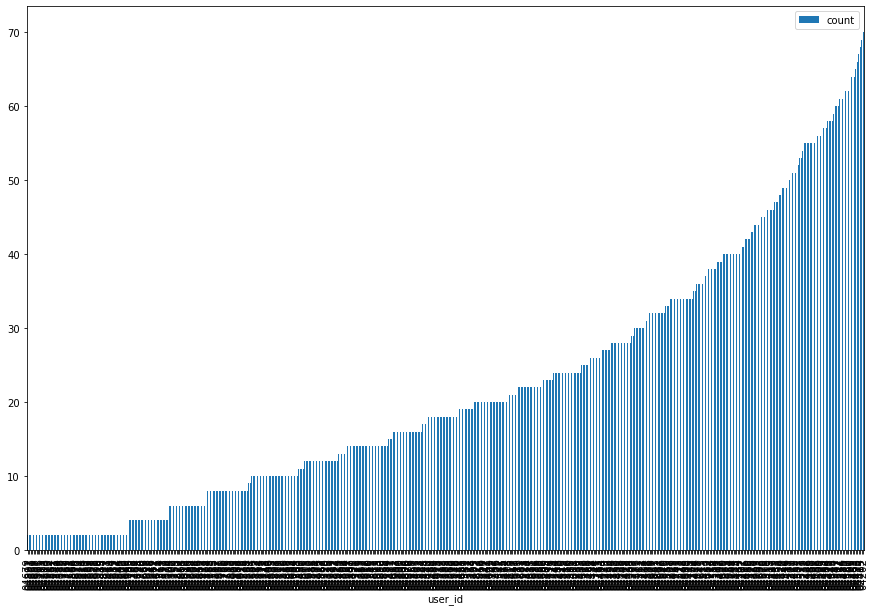

In [9]:
(
    directory_df
    .groupby('user_id')['user_img_id']
    .count()
    .to_frame('count')
    .sort_values('count')
    .plot(kind='bar', figsize=(15, 10))
)

In [10]:
# Get all classes from 10 samples till 60 samples
data_size = 20
class_count_required = 60

ids_testing = ( 
    directory_df
    .groupby('user_id')['user_img_id']
    .count() < data_size
)

ids_to_keep = ( 
    directory_df
    .groupby('user_id')['user_img_id']
    .count() >= data_size
)

ids_to_keep = ids_to_keep[ids_to_keep].index
ids_test = ids_testing[ids_testing].index

subset_directory_df = (
    directory_df
    .loc[directory_df['user_id'].isin(ids_to_keep)]
    .sample(frac=1)
    .groupby('user_id')
    .head(class_count_required)
    .copy()
)

test_df = (
    directory_df
    .loc[directory_df['user_id'].isin(ids_test)]
    .sample(frac=1)
    .copy()
)

old_unique = directory_df['user_id'].nunique()
new_unique = subset_directory_df['user_id'].nunique()
print(f"There are {new_unique}/{old_unique} ({new_unique/old_unique*100:.2f}%)" +
      " unique IDs remaining.")

test_unique = test_df['user_id'].nunique()
print(f"There are {test_unique} IDS for testing")

There are 265/568 (46.65%) unique IDs remaining.
There are 303 IDS for testing


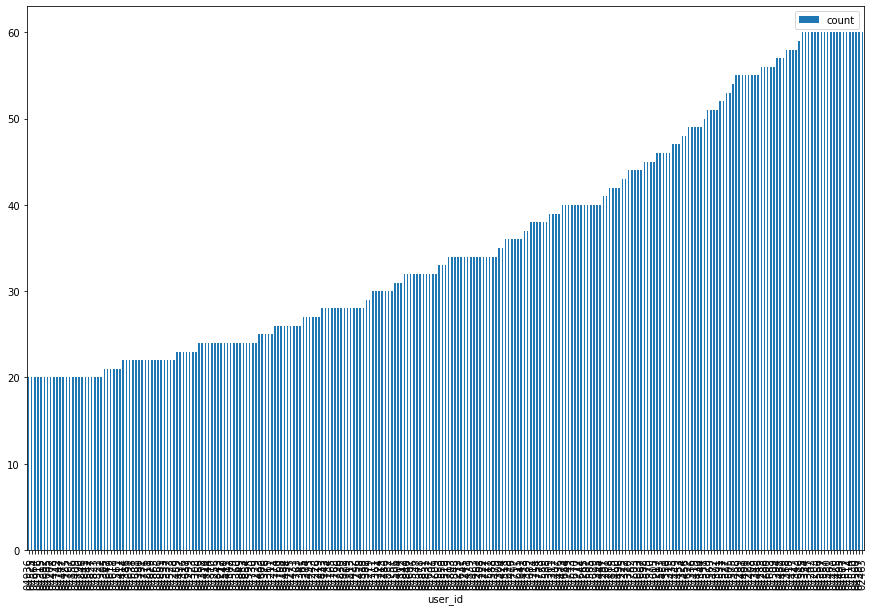

In [11]:
(
    subset_directory_df
    .groupby('user_id')['user_img_id']
    .count()
    .to_frame('count')
    .sort_values('count')
    .plot(kind='bar', figsize=(15, 10))
)

In [12]:
counts = (
    subset_directory_df
    .groupby('user_id')['user_img_id']
    .count()
    .to_frame('count')
    .sort_values('count')
    .reset_index(drop=False)
    .assign(augmentation_needed=lambda 
            df: class_count_required-df['count'])
)

In [13]:
counts.head()

,user_id,count,augmentation_needed
0,04936,20,40
1,04525,20,40
2,04664,20,40
3,04916,20,40
4,04315,20,40


In [14]:
counts_test = (
    test_df
    .groupby('user_id')['user_img_id']
    .count()
    .to_frame('count')
    .sort_values('count')
    .reset_index(drop=False)
    .assign(augmentation_needed=lambda 
            df: class_count_required-df['count'])
)
counts_test['augmentation_needed'] = 0

In [15]:
counts_test.head()

,user_id,count,augmentation_needed
0,04200,2,0
1,04845,2,0
2,04858,2,0
3,04623,2,0
4,04860,2,0


In [16]:
subset_directory_df.head()
subset_directory_df_sorted = (
    subset_directory_df.sort_values(by=['path'])
)
test_df_sorted = test_df.sort_values(by=['path'])

In [17]:
from imgaug import augmenters as iaa

def augment_image(image):
    # https://github.com/aleju/imgaug
    augmentations = iaa.Sequential([
        iaa.SaltAndPepper(0.03),
    #     iaa.AdditiveGaussianNoise(scale=(0, 0.2*255)),
    #     iaa.AdditiveLaplaceNoise(scale=(0, 0.03*255)),
    #     iaa.CoarseDropout((0.01, 0.04), size_percent=(0.02, 0.18))
    ])
    seq = augmentations
    return seq(image=image)

In [18]:
from tqdm import tqdm

def read_image(file_path, augment=False):
    img = cv2.imread(file_path, 0)
    img = cv2.resize(img, (32, 32))
    if augment:
        img = augment_image(img)
    return img

In [19]:
def load_images_augment(dataframe, augment_df):
    _labels = []

    items = []
    for _, row in tqdm(augment_df.iterrows(), total=augment_df.shape[0]):
        user_id = row['user_id']
        augmentation_needed = row['augmentation_needed']
        
        _labels.append(user_id)
        lbl = _labels.index(user_id)
        
        relevant_subset = dataframe.loc[dataframe['user_id']==user_id].copy()
        
        for _, row in relevant_subset.iterrows():
            img = read_image(row['path'], augment=False)
            items.append((img, lbl))
            
        if augmentation_needed > relevant_subset.shape[0]:
            items_to_augment = relevant_subset.sample(augmentation_needed, replace=True)    
        else:
            items_to_augment = relevant_subset.sample(augmentation_needed)
        
        for _, row in items_to_augment.iterrows():
            img = read_image(row['path'], augment=True)
            items.append((img, lbl))
    return items

In [20]:
items = load_images_augment(subset_directory_df_sorted, counts)

assert len(items) == counts.shape[0] * class_count_required

100%|██████████| 265/265 [00:09<00:00, 28.63it/s]


In [21]:
test_items = load_images_augment(test_df_sorted, counts_test)

100%|██████████| 303/303 [00:01<00:00, 257.23it/s]


In [22]:
def make_pairs(images, labels, num_classes):
    pairImages = []
    pairLabels = []

    idx = [np.where(labels == i)[0] for i in range(0, num_classes)]

    for idxA in tqdm(range(len(images))):
        currentImage = images[idxA]
        label = labels[idxA]
        idxB = np.random.choice(idx[label])
        posImage = images[idxB]

        pairImages.append([currentImage, posImage])
        pairLabels.append([1])

        negIdx = np.where(labels != label)[0]
        negImage = images[np.random.choice(negIdx)]

        pairImages.append([currentImage, negImage])
        pairLabels.append([0])

    return np.array(pairImages), np.array(pairLabels)

In [23]:
train_test_split = 0.7
split = int(train_test_split * new_unique) * class_count_required

with open ('identities.txt', 'w+') as f:
    f.write(', '.join([img for img in subset_directory_df_sorted['path'][:split]]) + '\n')
    f.write(', '.join([img for img in subset_directory_df_sorted['path'][split:]]) + '\n')

trainX = np.array([x[0] for x in items[:split]])
trainY = np.array([x[1] for x in items[:split]])

valX = np.array([x[0] for x in items[split:]])
valY = np.array([x[1] for x in items[split:]])

testX = np.array([x[0] for x in test_items])
testY = np.array([x[1] for x in test_items])

trainX = trainX / 255.0
valX = valX / 255.0
testX = testX / 255.0

# add a channel dimension to the images
trainX = np.expand_dims(trainX, axis=-1)
valX = np.expand_dims(valX, axis=-1)
testX = np.expand_dims(testX, axis=-1)

(pairTrain, labelTrain) = make_pairs(trainX, trainY, num_classes=new_unique)
(pairVal, labelVal) = make_pairs(valX, valY, num_classes=new_unique)
(pairTest, labelTest) = make_pairs(testX, testY, num_classes=test_unique)

100%|██████████| 2759/2759 [00:00<00:00, 45966.57it/s]



# build model

In [ ]:
IMG_SHAPE = (32, 32, 1)
BATCH_SIZE = 64
EPOCHS = 500

In [ ]:
def build_model_20(inputShape, embeddingDim=48):
    inputs = Input(inputShape)
    x = Conv2D(48, (3, 3), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(48, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    pooledOutput = GlobalAveragePooling2D()(x)
    outputs = Dense(embeddingDim)(pooledOutput)

    model = Model(inputs, outputs, name = 'model_20')

    return model


In [ ]:
def build_model_60(inputShape, embeddingDim=48):
    inputs = Input(inputShape)
    x = Conv2D(64, (3, 3), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(48, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    pooledOutput = GlobalAveragePooling2D()(x)
    outputs = Dense(embeddingDim)(pooledOutput)

    model = Model(inputs, outputs, name = 'model_60')

    return model

In [ ]:
def build_model_130(inputShape, embeddingDim=48):
    inputs = Input(inputShape)
    x = Conv2D(128, (5, 5), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(80, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(48, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    pooledOutput = GlobalAveragePooling2D()(x)
    outputs = Dense(embeddingDim)(pooledOutput)

    model = Model(inputs, outputs, name = 'model_130')

    return model

In [ ]:
def build_model_250(inputShape, embeddingDim=48):
    inputs = Input(inputShape)
    x = Conv2D(128, (5, 5), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(96, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(96, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    pooledOutput = GlobalAveragePooling2D()(x)
    outputs = Dense(embeddingDim)(pooledOutput)

    model = Model(inputs, outputs, name = 'model_250')

    return model

In [ ]:
def euclidean_distance(vectors):
	# unpack the vectors into separate lists
    featsA = vectors[0]
    featsB = vectors[1]
	# compute the sum of squared distances between the vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1,
        keepdims=True)
	# return the euclidean distance between the vectors
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))

def plot_training(H, plotPath):
    # construct a plot that plots and saves the training history
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H.history["loss"], label="train_loss")
    plt.plot(H.history["val_loss"], label="val_loss")
    plt.plot(H.history["accuracy"], label="train_acc")
    plt.plot(H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig(plotPath)

In [ ]:
import datetime
from pathlib import Path
from tensorflow.keras.callbacks import EarlyStopping

def train_model(model_fun, save_name, train = True):
    print(f'Training model: {save_name}')
    
    log_dir = "tensor_logs/" + save_name + '_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

    base_out = Path('models')
    model_path = base_out / f'model_{save_name}_temp'
    model_path.mkdir(parents=True, exist_ok=True)
    plot_path = base_out / f'plot_{save_name}.png'

    imgA = Input(shape=IMG_SHAPE)
    imgB = Input(shape=IMG_SHAPE)
    featureExtractor = model_fun(IMG_SHAPE)
    featsA = featureExtractor(imgA)
    featsB = featureExtractor(imgB)

    distance = Lambda(euclidean_distance)([featsA, featsB])
    outputs = Dense(1, activation="sigmoid")(distance)
    model = Model(inputs=[imgA, imgB], outputs=outputs)

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


    if not train:
        return
    
    early_stopping = EarlyStopping(mode='min', patience=5, verbose=1)
    
    history = model.fit(
        [pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
        validation_data=([pairVal[:, 0], pairVal[:, 1]], labelVal[:]),
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[tensorboard_callback, early_stopping])

    model.save(str(model_path))
#     plot_training(history, plot_path)
    return model

In [ ]:
train = True
model20 = train_model(build_model_20, 'sn_20', train)
model60 = train_model(build_model_60, 'sn_60', train)
model130 = train_model(build_model_130, 'sn_130', train)
model250 =train_model(build_model_250, 'sn_250', train)

# Train

# Final step: Testing + Comparing our models

In [147]:
model_20_test = model20.evaluate([pairTest[:, 0], pairTest[:, 1]], labelTest[:])

model_60_test = model60.evaluate([pairTest[:, 0], pairTest[:, 1]], labelTest[:])

model_130_test = model130.evaluate([pairTest[:, 0], pairTest[:, 1]], labelTest[:])

model_250_test = model250.evaluate([pairTest[:, 0], pairTest[:, 1]], labelTest[:])

173/173 [==============================] - 1s 5ms/step - loss: 0.3023 - accuracy: 0.8686

In [148]:
print("Model 20:")
print(f"Test loss: {model_20_test[0]:.3f} | Test accuracy {model_20_test[1]}")
print("Model 60:")
print(f"Test loss: {model_60_test[0]:.3f} | Test accuracy {model_60_test[1]}")
print("Model 130:")
print(f"Test loss: {model_130_test[0]:.3f} | Test accuracy {model_130_test[1]}")
print("Model 250:")
print(f"Test loss: {model_250_test[0]:.3f} | Test accuracy {model_250_test[1]}")

Model 20:
Model 60:
Model 130:
Model 250:
Test loss: 0.302 | Test accuracy 0.8686118125915527


terminal command for displaying the board: tensorboard --logdir=./tensor_logs

# Convert to Tensorflow lite model

In [24]:
def convert_model(model_path, output_model):
    converter = tf.lite.TFLiteConverter.from_saved_model(model_path)
    tflite_model = converter.convert()

    open(output_model, "wb").write(tflite_model)
    return tflite_model

    
def convert_model_optimized_float16(model_path, output_model):
    converter = tf.lite.TFLiteConverter.from_saved_model(model_path)
    # Optimizations
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_types = [tf.float16]

    tflite_quant_model = converter.convert()

    open(output_model, "wb").write(tflite_quant_model)
    return tflite_quant_model

def convert_model_optimized_drq(model_path, output_model):
    converter = tf.lite.TFLiteConverter.from_saved_model(model_path)
    # Optimizations
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    tflite_quant_model = converter.convert()

    open(output_model, "wb").write(tflite_quant_model)
    return tflite_quant_model



def interpret_model(tflite_model_path, pairTest):
        
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Resize interpreter to match correct size of input
    interpreter.resize_tensor_input(input_details[0]['index'], (5518, 32, 32, 1))
    interpreter.resize_tensor_input(input_details[1]['index'], (5518, 32, 32, 1))

    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    pairTest = pairTest.astype('float32')
    interpreter.set_tensor(input_details[0]['index'], pairTest[:,0])
    interpreter.set_tensor(input_details[1]['index'], pairTest[:,1])

    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])

    return output_data


In [31]:
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn import metrics
from scipy.optimize import brentq
from scipy.interpolate import interp1d

def model_metrics(labels, predictions):

  fpr, tpr, thresholds = metrics.roc_curve(labels, predictions)
  eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
  thresh = interp1d(fpr, thresholds)(eer)
  # Plot ROC curve
  plot_roc_curve (fpr,tpr)

  #   # Print accuracy
  accurate_count = 0
  for index in range(len(predictions)):
    predictions[index] = np.rint(predictions[index])
    if predictions[index] == labels[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(predictions)
  auc = metrics.auc(fpr, tpr)
  print("Accuracy", accuracy)
  print("AUC",auc)
  print("EER",eer)
  


def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show()    

-----TensorFlow Lite----
.\output\converted_model20.tflite
Original 


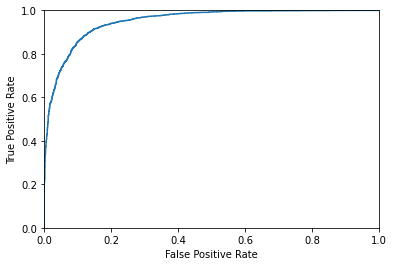

Accuracy 0.8475897064153679
AUC 0.9504895573234178
EER 0.11824936571221456
Float 16 quantization optimization


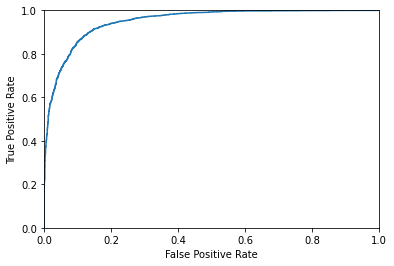

Accuracy 0.8474084813338166
AUC 0.9504850250542527
EER 0.11824936571221457
Dynamic range optimization


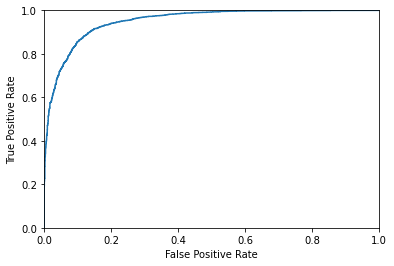

Accuracy 0.8472272562522654
AUC 0.9504774055872501
EER 0.1188836534976093
-----TensorFlow----
173/173 [==============================] - 3s 13ms/step - loss: 0.3361 - accuracy: 0.8476


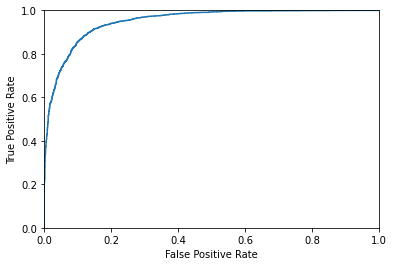

Accuracy 0.8475897064153679
AUC 0.9504895573234178
EER 0.11824936571221456
Test loss: 0.336 | Test accuracy 0.8475897312164307
-----TensorFlow Lite----
.\output\converted_model60.tflite
Original 


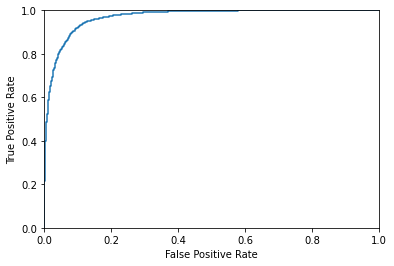

Accuracy 0.8867343240304458
AUC 0.9691741325401031
EER 0.09061254077565649
Float 16 quantization optimization


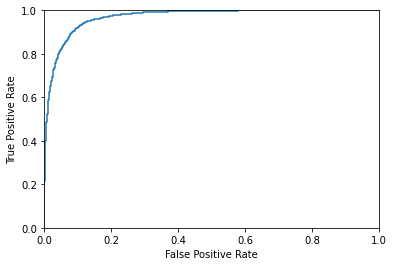

Accuracy 0.8867343240304458
AUC 0.9691795187150531
EER 0.09061254077582567
Dynamic range optimization


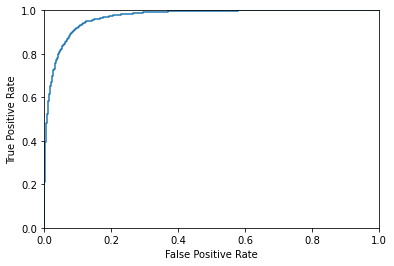

Accuracy 0.8870967741935484
AUC 0.9692102593233045
EER 0.09133744110184475
-----TensorFlow----
173/173 [==============================] - 3s 18ms/step - loss: 0.2643 - accuracy: 0.8867


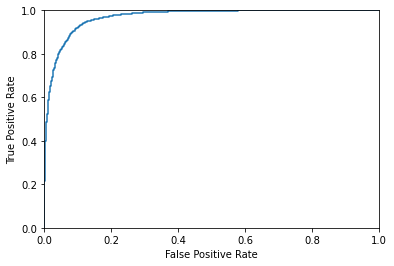

Accuracy 0.8867343240304458
AUC 0.969174132540103
EER 0.09061254077564489
Test loss: 0.264 | Test accuracy 0.8867343068122864
-----TensorFlow Lite----
.\output\converted_model130.tflite
Original 


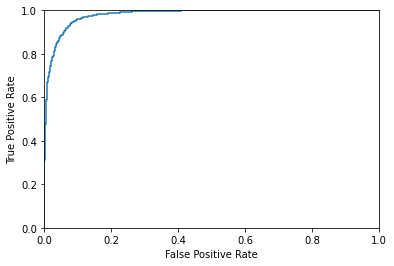

Accuracy 0.9139180862631389
AUC 0.9801472159846959
EER 0.07249003262051468
Float 16 quantization optimization


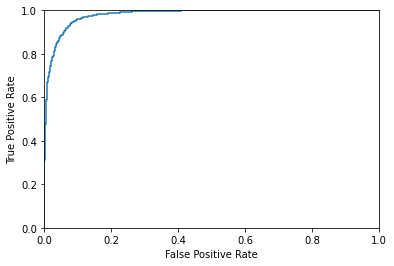

Accuracy 0.9139180862631389
AUC 0.9801491865365071
EER 0.07249003262051636
Dynamic range optimization


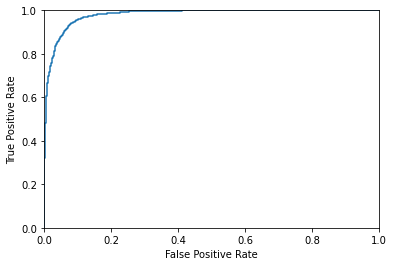

Accuracy 0.9133744110184849
AUC 0.9801552295620606
EER 0.07299746284886102
-----TensorFlow----
173/173 [==============================] - 6s 36ms/step - loss: 0.2108 - accuracy: 0.9139


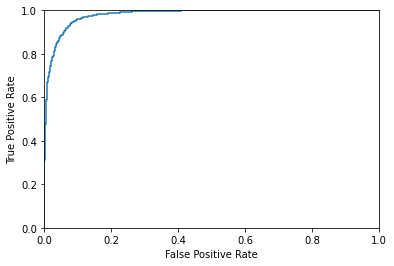

Accuracy 0.9139180862631389
AUC 0.9801472159846959
EER 0.07277999275099671
Test loss: 0.211 | Test accuracy 0.9139180779457092
-----TensorFlow Lite----
.\output\converted_model250.tflite
Original 


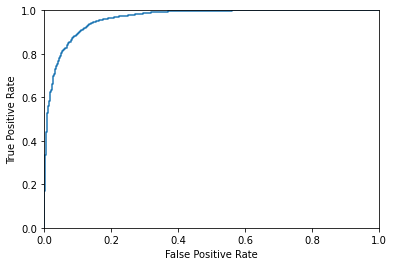

Accuracy 0.8696991663646249
AUC 0.9642532705576832
EER 0.10275462123957955
Float 16 quantization optimization


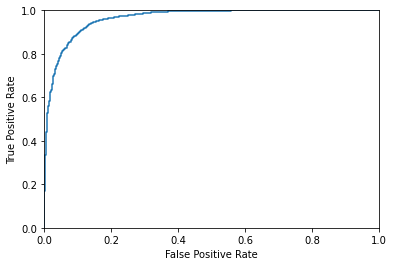

Accuracy 0.8698803914461761
AUC 0.9642568175509428
EER 0.10257339615834969
Dynamic range optimization


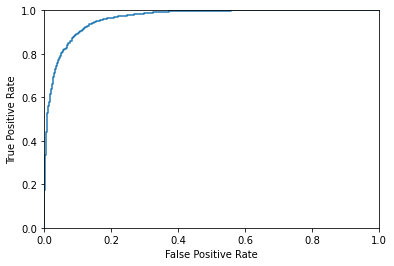

Accuracy 0.8706052917723813
AUC 0.9642749466276042
EER 0.1025733961580294
-----TensorFlow----
173/173 [==============================] - 4s 21ms/step - loss: 0.2961 - accuracy: 0.8697


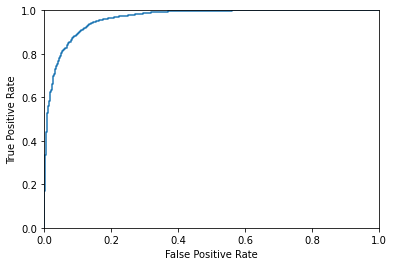

Accuracy 0.8696991663646249
AUC 0.9642531391875626
EER 0.10257339615893431
Test loss: 0.296 | Test accuracy 0.8696991801261902


In [32]:
  
# TensorFlow Lite

output_model = ['.\output\converted_model20.tflite', '.\output\converted_model60.tflite', '.\output\converted_model130.tflite','.\output\converted_model250.tflite' ]
tflite_model_file_optimized_float = ['.\output\converted_model20_opt_float.tflite', '.\output\converted_model60_opt_float.tflite', '.\output\converted_model130_opt_float.tflite','.\output\converted_model250_opt_float.tflite' ]
tflite_model_file_optimized_drq = ['.\output\converted_model20_opt_drq.tflite', '.\output\converted_model60_opt_drq.tflite', '.\output\converted_model130_opt_drq.tflite','.\output\converted_model250_opt_drq.tflite' ]
saved_models = [".\output\model_sn_20_temp", ".\output\model_sn_60_temp", ".\output\model_sn_130_temp", ".\output\model_sn_250_temp"]


for i in range(len(output_model)):
    print("-----TensorFlow Lite----")
    print(output_model[i])
    print("Original ")
    # Original optimizations
    convert_model(saved_models[i], output_model[i])
    output_data = interpret_model(output_model[i], pairTest)
    model_metrics(labelTest, output_data)



    print("Float 16 quantization optimization")
    convert_model_optimized_float16(saved_models[i], tflite_model_file_optimized_float[i])
    output_data = interpret_model(tflite_model_file_optimized_float[i], pairTest)
    
    model_metrics(labelTest, output_data)


    print("Dynamic range optimization")
    convert_model_optimized_drq(saved_models[i], tflite_model_file_optimized_drq[i])
    output_data = interpret_model(tflite_model_file_optimized_drq[i], pairTest)
    model_metrics(labelTest, output_data)

    # TensorFlow
    print("-----TensorFlow----")
    model = load_model(saved_models[i])
    preds = model.predict([pairTest[:, 0], pairTest[:, 1]])
    model_20_test = model.evaluate([pairTest[:, 0], pairTest[:, 1]], labelTest[:])
    model_metrics(labelTest, preds)

    print(f"Test loss: {model_20_test[0]:.3f} | Test accuracy {model_20_test[1]}")